# Data processing3.0

### Import packages

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from itertools import chain

import csv
import re
import pickle

### Import data

In [2]:
df = pd.read_csv('FoodReviews/Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
new_df = df.get(['Score','Text'])
new_df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


### Score distribution

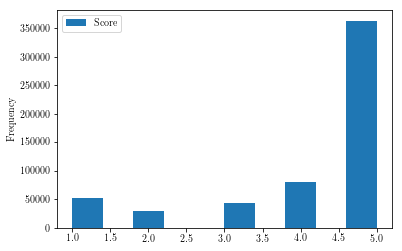

The data set contains 568454 reviews.
Of which 443777 (0.780674) are positive reviews (score 4-5).
And 124677 (0.219326) are negative reviews (score 1-3).


In [5]:
#plt.hist(new_df.get(['Score']).value);
new_df.plot.hist()
plt.show()

nbr_points = len(new_df.Score)
pos_score = 0
neg_score = 0
for score in new_df.Score:
    if score <= 3:
        neg_score += 1
    else:
        pos_score += 1
        
print('The data set contains %d reviews.' %nbr_points)
print('Of which %d (%f) are positive reviews (score 4-5).' %(pos_score,pos_score/nbr_points))
print('And %d (%f) are negative reviews (score 1-3).' %(neg_score,neg_score/nbr_points))

In [6]:
# Remove <this> and make lowercase
texts = new_df.Text.values
#print(texts)
j=0
texts_revised = []
for row in texts:
    tmp = re.sub(r'<.+?>', ' ', row)
    texts_revised.append(tmp.lower())

In [7]:
dff = new_df.copy()
dff['Text'] = texts_revised.copy()
dff.head()

,Score,Text
0,5,i have bought several of the vitality canned d...
1,1,product arrived labeled as jumbo salted peanut...
2,4,this is a confection that has been around a fe...
3,2,if you are looking for the secret ingredient i...
4,5,great taffy at a great price. there was a wid...


### Redo labels (score)

In [8]:
labels = []
for val in dff.Score.values:
    if val<=3:
        labels.append(0)
    else:
        labels.append(1)    

### Turn words into indeces

In [9]:
from keras.preprocessing.text import Tokenizer,text_to_word_sequence

pre_num_words = 100000 #number of words kept in the vocabulary
pre_num_tokenizer = Tokenizer(num_words=pre_num_words, filters='!?"#&(),-./:;<=>@[\]^_`{|}~',
                          lower=True)
pre_num_tokenizer.fit_on_texts(dff.Text.values)        

Using TensorFlow backend.


In [10]:
import operator

least_frequency = 5
counts = pre_num_tokenizer.word_counts
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1))
sorted_counts_shorter = sorted_counts.copy()

for row in sorted_counts:
    if row[1] < least_frequency:
        sorted_counts_shorter.remove(row)
    else:
        break

In [11]:
print('List of word frequencies above %d:' %least_frequency)
print(sorted_counts_shorter)

List of word frequencies above 5:
[('tastelessly', 5), ('nate', 5), ('sloth', 5), ('xi', 5), ('fluted', 5), ('tentacle', 5), ('sabrina', 5), ('saloon', 5), ('mandeling', 5), ('bedbath', 5), ('tassimodirect', 5), ('rudolph', 5), ('bedpost', 5), ("'hit'", 5), ("fall's", 5), ('grabby', 5), ('granddad', 5), ('sassafrass', 5), ('beavers', 5), ('dilly', 5), ('rifle', 5), ('opossums', 5), ('candyland', 5), ('dippin', 5), ('crockets', 5), ('globbs', 5), ("'certain", 5), ('mules', 5), ('tictacs', 5), ('versital', 5), ('essentials®', 5), ('zon', 5), ('elixers', 5), ('dogadvisor', 5), ('disatified', 5), ("vinegar's", 5), ('parmessan', 5), ('aloof', 5), ("ww's", 5), ('forefinger', 5), ('mopping', 5), ('woofers', 5), ('kilter', 5), ('consitancy', 5), ('levening', 5), ('restocks', 5), ('lagers', 5), ('happymunchies', 5), ('citrict', 5), ("'benefits'", 5), ('mol', 5), ('undon', 5), ('strianese', 5), ('galactooligosaccharides*', 5), ('coordinated', 5), ("puddin'", 5), ("beefeaters'", 5), ('fillin', 5)

In [12]:
print('Number of unique words:')
print(len(counts))
print('Number of words with a frequency of at least %d:' %least_frequency)
print(len(sorted_counts_shorter))

Number of unique words:
129138
Number of words with a frequency of at least 5:
46207


### Get a nicely limited tokenizer

In [13]:
num_words = 46210 #number of words kept in the vocabulary
num_tokenizer = Tokenizer(num_words=num_words, filters='!?"#&(),-./:;<=>@[\]^_`{|}~',
                          lower=True)
num_tokenizer.fit_on_texts(dff.Text.values)        

### Create number representation of reviews with tokenizer

In [14]:
token_num = num_tokenizer.texts_to_sequences(dff.Text.values)

print(token_num[0])

[2, 16, 123, 317, 7, 1, 4998, 516, 102, 51, 203, 3, 16, 116, 27, 39, 5, 29, 7, 28, 181, 1, 40, 619, 47, 25, 4, 2635, 57, 4, 1179, 442, 3, 6, 609, 98, 12, 5301, 8, 1775, 3, 93, 8758, 9, 40, 98, 57, 139]


### Get dictionaries for word<->index

In [15]:
word_to_ix = num_tokenizer.word_index
keys = list(word_to_ix.keys())

In [16]:
word_to_ix = num_tokenizer.word_index
word_to_ix['ZERO'] = 0

ix_to_word = {}
ix_to_word['0'] = 'ZERO'
i = 0
for val in keys:
    i+=1
    ix_to_word[str(i)] = val

In [17]:
indexer = num_tokenizer.word_index
indexer

{'the': 1,
 'i': 2,
 'and': 3,
 'a': 4,
 'to': 5,
 'it': 6,
 'of': 7,
 'is': 8,
 'this': 9,
 'for': 10,
 'in': 11,
 'my': 12,
 'that': 13,
 'but': 14,
 'with': 15,
 'have': 16,
 'not': 17,
 'you': 18,
 'are': 19,
 'was': 20,
 'they': 21,
 'as': 22,
 'on': 23,
 'so': 24,
 'like': 25,
 'these': 26,
 'them': 27,
 'good': 28,
 'be': 29,
 'or': 30,
 'at': 31,
 'one': 32,
 'just': 33,
 'taste': 34,
 'if': 35,
 'very': 36,
 'great': 37,
 'coffee': 38,
 'all': 39,
 'product': 40,
 'flavor': 41,
 'from': 42,
 "it's": 43,
 'tea': 44,
 'can': 45,
 'when': 46,
 'more': 47,
 'we': 48,
 'has': 49,
 'me': 50,
 'food': 51,
 'love': 52,
 'had': 53,
 'will': 54,
 'would': 55,
 'out': 56,
 'than': 57,
 'no': 58,
 'get': 59,
 'other': 60,
 'some': 61,
 'up': 62,
 'about': 63,
 'really': 64,
 'only': 65,
 'too': 66,
 'much': 67,
 "don't": 68,
 'an': 69,
 'your': 70,
 'also': 71,
 'amazon': 72,
 'because': 73,
 'time': 74,
 'use': 75,
 'little': 76,
 'were': 77,
 'there': 78,
 'do': 79,
 'what': 80,
 'which

### A sentence corresponding to dictionary indices

In [18]:
sentence_ix = 10
original_sentence = dff.Text.values[sentence_ix]

tmp = []
for val in token_num[sentence_ix]:
    tmp.append(ix_to_word[str(val)])

processed_sentence = ' '.join(tmp)

print('Original review sentence:')
print(original_sentence)
print('Processed review sentence:')
print(processed_sentence)

Original review sentence:
i don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  we picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  when we realized that we simply couldn't find it anywhere in our city we were bummed.  now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.  if you love hot sauce..i mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of tequila picante gourmet de inclan.  just realize that once you taste it, you will never want to use any other sauce.  thank you for the personal, incredible service!
Processed review sentence:
i don't know if it's the cactus or the tequila or just the unique combination of ingredients but the flavour of this hot sauce makes it one of a kind we picked up a bottle once on a trip we were on

### Check distribution of tokenized reviews compared to original

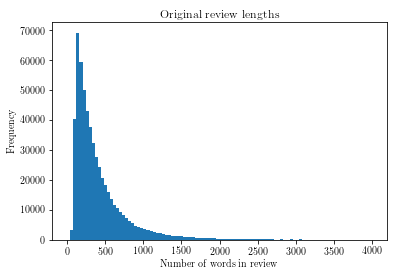

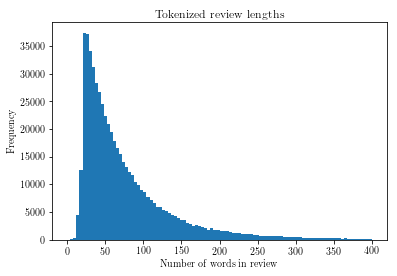

In [19]:
# get review lengths
review_lengths = []
for row in dff.Text.values:
    review_lengths.append(len(row))
    
plt.hist(review_lengths,range=(0,4000),bins=100)
plt.xlabel('Number of words in review')
plt.ylabel('Frequency')
plt.title('Original review lengths')
plt.show()

review_lengths_tokenized = []
for row in token_num:
    review_lengths_tokenized.append(len(row))
    
plt.hist(review_lengths_tokenized,range=(0,400),bins=100)
plt.xlabel('Number of words in review')
plt.ylabel('Frequency')
plt.title('Tokenized review lengths')
plt.show()

### Save fig

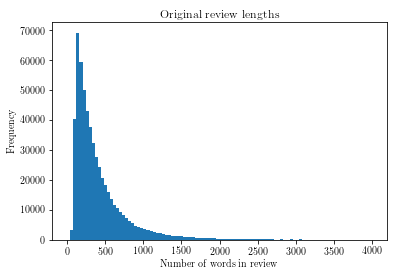

In [42]:
plt.hist(review_lengths,range=(0,4000),bins=100)
plt.xlabel('Number of words in review')
plt.ylabel('Frequency')
plt.title('Original review lengths')
plt.draw()
plt.savefig('img\\originalL.pgf')

In [21]:
import latexipy as lp

lp.latexify()  # Change to a serif font that fits with most LaTeX.

with lp.figure('words_processed'):  # saves in img/ by default.
    plt.hist(review_lengths,range=(0,4000),bins=100)
    plt.xlabel('Number of words in review')
    plt.ylabel('Frequency')
    plt.title('Original review lengths')
    plt.show()

with lp.figure('words_processed'):  # saves in img/ by default.
    plt.hist(review_lengths_tokenized,range=(0,400),bins=100)
    plt.xlabel('Number of words in review')
    plt.ylabel('Frequency')
    plt.title('Tokenized review lengths')
    plt.show()

### Pad review sequences and set a limit

In [102]:
from keras.preprocessing.sequence import pad_sequences

max_num_words = 100 #see distribution above
#token_word_pad = pad_sequences(token_word, maxlen=max_num_words, padding='post', truncating='post', value='ZERO')
token_num_pad = pad_sequences(token_num, maxlen=max_num_words, padding='post', truncating='post', value=0)

In [103]:
token_num_pad[0]

array([   2,   16,  123,  317,    7,    1, 4998,  516,  102,   51,  203,
          3,   16,  116,   27,   39,    5,   29,    7,   28,  181,    1,
         40,  619,   47,   25,    4, 2635,   57,    4, 1179,  442,    3,
          6,  609,   98,   12, 5301,    8, 1775,    3,   93, 8758,    9,
         40,   98,   57,  139,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

### TOKENIZE based on padded sequence

In [35]:
# # NO GO: takes forever!
# token_word_pad = []
# for row in token_num_pad:
#     token_vec = []
#     for val in row:
#         token = ix_to_word[str(val)]
#         token_vec.append(token)
#     token_word_pad.append(token_vec)

KeyboardInterrupt: 

In [ ]:
# print("Length of token_word_pad for first review: %d" %len(token_word_pad[0]))
# print("Length of token_num_pad: %d" %len(token_num_pad[0]))

# print("First review, tokens and numbers:")
# print(token_word_pad[0])
# print(token_num_pad[0])

### Save to a data frame

In [104]:
type(token_num_pad)
token_num_pad.shape
token_num_pad_list = list(token_num_pad)

In [105]:
d = {'Score': dff.Score.values, 'Label': labels, 'WordIndeces': token_num_pad_list}
review_df = pd.DataFrame(data=d)
review_df.head()

,Score,Label,WordIndeces
0,5,1,"[2, 16, 123, 317, 7, 1, 4998, 516, 102, 51, 20..."
1,1,0,"[40, 372, 2210, 22, 5809, 1960, 1075, 1, 1075,..."
2,4,1,"[9, 8, 4, 7126, 13, 49, 82, 275, 4, 162, 9315,..."
3,2,0,"[35, 18, 19, 250, 10, 1, 2625, 570, 11, 24049,..."
4,5,1,"[37, 3580, 31, 4, 37, 86, 78, 20, 4, 2073, 214..."


### Save tokenized data

In [106]:
with open('tokenized_reviews.pickle', 'wb') as handle:
    pickle.dump(review_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Check save

In [107]:
with open('tokenized_reviews.pickle', 'rb') as handle:
    saved_df = pickle.load(handle)

In [46]:
saved_df.head()

,Score,Label,Text
0,5,1,"[i, have, bought, several, of, the, vitality, ..."
1,1,0,"[product, arrived, labeled, as, jumbo, salted,..."
2,4,1,"[this, is, a, confection, that, has, been, aro..."
3,2,0,"[if, you, are, looking, for, the, secret, ingr..."
4,5,1,"[great, taffy, at, a, great, price, ., there, ..."


## Save dictionaries

In [108]:
with open('word_to_ix.pickle', 'wb') as handle:
    pickle.dump(word_to_ix, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ix_to_word.pickle', 'wb') as handle:
    pickle.dump(ix_to_word, handle, protocol=pickle.HIGHEST_PROTOCOL)